# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [95]:
class GradientBoosting():
    
    def __init__(self, n_estimators, max_depth, learning_rate = 0.1, optimal_weight = True):
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.optimal_weight=optimal_weight
        
    def fit(self, x, y):
        
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        
        self.x = x
        self.y = y
        self.trees=[tree]        
        self.weights = [[1] if self.optimal_weight else np.ones(self.n_estimators)][0]
        
        change = 0
        for i in range(self.n_estimators-1):
            change += self.trees[i].predict(x)
            self._fit_predict_tree(y - change)
            
    def _fit_predict_tree(self, y):
        
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(self.x, y)
        self.trees.append(tree) 
        
        if self.optimal_weight:
            self.weights.append(minimize(lambda x: mean_squared_error(self.y, self.predict(self.x) + x * tree.predict(self.x)), 1).x)
            
        return self.weights[-1] * self.learning_rate * tree.predict(self.x)    
        
    def predict(self,x):
        return self.trees[0].predict(x) + sum([self.weights[i] * self.learning_rate*self.trees[i].predict(x) for i in range(1, len(self.trees)-1)])

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [69]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [96]:
np.random.seed(19052019)

model = GradientBoosting(n_estimators = 70, max_depth = 6, learning_rate = 0.3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [97]:
mean_squared_error(y_test, y_pred)

13.426134427891922

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [3]:
import pandas as pd
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [4]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [6]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:54:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6978682941626562

In [14]:
from catboost import CatBoostClassifier
X_train = train.drop(['dep_delayed_15min'],axis=1).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

categorical = [0, 1, 2, 4, 5, 6]

model = CatBoostClassifier(
    iterations=200,
)

model.fit(
    X_train_part, y_train_part,
    cat_features=categorical,
    eval_set=(X_valid, y_valid),
    verbose=False,
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [15]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7608368551290093

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [56]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [57]:
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
    def fit_predict (self, X):
        self.X_mask = np.zeros(len(X))
        self.X_clusters = np.zeros(len(X))
        self.X = X
        n__of_cluster = 1
        
        for i in range(len(X)):
            if self.X_mask[i] == 0:
                if self.count_neighbours(i):
                    self.grow_cluster(i, n__of_cluster)
                    n__of_cluster +=1
                else:
                    self.X_mask[i] = 1
        return self.X_clusters
                
    def grow_cluster(self, element, n__of_cluster):
        neighbours = self.find_neighbours(element)
        for i in neighbours:
            if self.X_mask[i] == 0:
                self.X_mask[i] = 1
                self.X_clusters[i] = n__of_cluster
                if self.count_neighbours(i):
                    self.grow_cluster(i, n__of_cluster)

    def find_neighbours(self, current):
        neighbours = []
        for i in range(len(self.X)):
            if self.dist(self.X[i], X[current]) <= self.eps and self.X_mask[i] == 0:
                neighbours.append(i)
        return neighbours
        
    def count_neighbours(self, i):
        counter = 0
        for j in range(len(self.X)):
            distance = self.dist(self.X[j], self.X[i])
            if distance<=self.eps:
                counter+=1
        if counter>=self.min_samples+1:
            return True
        else:
            return False
        
    @staticmethod
    def dist(a, b):
        return distance.euclidean(a, b)

Проверим себя на простом примере:

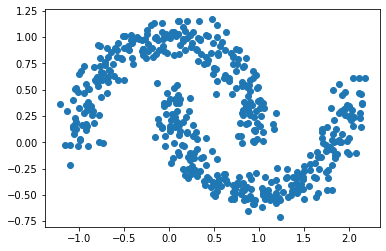

In [102]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

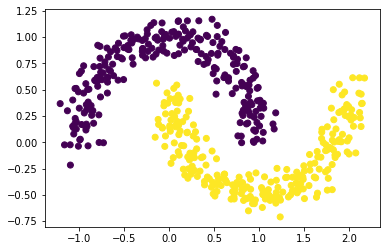

In [104]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

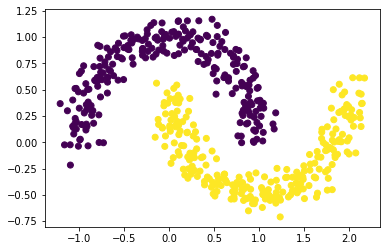

In [103]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

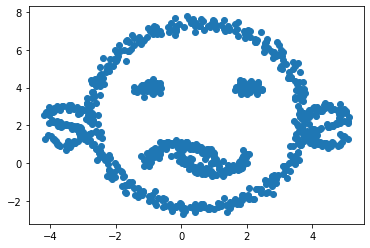

In [62]:
from sklearn.datasets import make_blobs, make_circles, make_moons, make_s_curve

X, _ = make_moons(n_samples=200, noise=0.12)
x, _ = make_blobs(n_samples=100, centers= [(-1,4), (2,4)], cluster_std=0.2)
X = np.vstack([x, X])
x, _ = make_circles(n_samples=400, factor = 0.95,  noise=0.03)
x = x*5/[1.5, 1]+[0.5, 2.5]
X = np.vstack([x, X])


x, _ = make_s_curve(n_samples=100, noise=0.2, random_state=None)
x = x[:,::2]*[1, -1]/2+[4.5,2]
X = np.vstack([x, X])

x, _ = make_s_curve(n_samples=100, noise=0.2, random_state=None)
x = x[:,::2]/2+[-3.5,2]
X = np.vstack([x, X])

plt.scatter(X[:,0], X[:,1])
plt.show()

правая часть смайлика: дедлайн перенесли

левая часть смайлика: на 12 часов

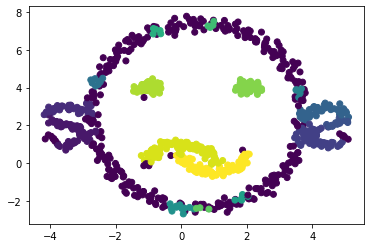

In [63]:
clusters = dbscan(eps=0.3, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

"правильным" он получается если eps=0.6, но так он самый красивый

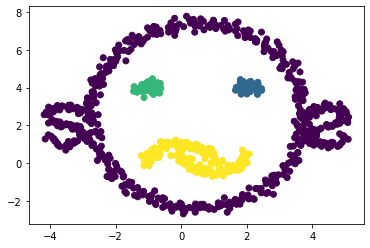

In [64]:
clusters = dbscan(eps=0.6, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

даже пытаться не буду

In [105]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 8 ms


In [106]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 7.01 s
